# Libraries


In [1]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedGroupKFold,
    StratifiedKFold
)
from sklearn.preprocessing import ( 
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.compose import (
    ColumnTransformer,
)
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn import set_config
from typing import List, Tuple
from glob import glob

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap

# Configuration


In [2]:
# Global configurations for sklearn:
set_config(transform_output="pandas")

# Global configurations for pandas:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None)

# Global configurations for polars:
pl.Config.activate_decimals(True).set_tbl_hide_column_data_types(True)
pl.Config(
    **dict(
        tbl_formatting="ASCII_FULL_CONDENSED",
        tbl_hide_column_data_types=False,
        tbl_hide_dataframe_shape=True,
        fmt_float="mixed",
        tbl_cell_alignment="CENTER",
        tbl_hide_dtype_separator=True,
        tbl_cols=100,
        tbl_rows=50,
        fmt_str_lengths=100,
    )
)

In [3]:
ROOT_DIR = "data/"
TRAIN_DIR = ROOT_DIR + "train/"
TEST_DIR = ROOT_DIR + "test/"

SEED = 42

# Functions


In [4]:
class DataFrameProcessor:
    """Dataframe processing class."""

    @staticmethod
    def convert_types(df: pl.DataFrame) -> pl.DataFrame:
        """Converts columns' data types for memory.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if column == "target":
                df = df.with_columns(pl.col(column).cast(pl.Int8))
            elif column in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(column).cast(pl.Int32))
            elif column == "date_decision":
                df = df.with_columns(pl.col(column).cast(pl.Date))
            elif column[-1] in ("P", "A"):
                df = df.with_columns(pl.col(column).cast(pl.Float64))
            elif column[-1] == "M":
                df = df.with_columns(pl.col(column).cast(pl.String))
            elif column[-1] == "D":
                df = df.with_columns(pl.col(column).cast(pl.Date))

        return df

    @staticmethod
    def date_processor(df: pl.DataFrame) -> pl.DataFrame:
        """Processes the date columns.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if column[-1] == "D":
                df = df.with_columns(pl.col(column) - pl.col("date_decision"))
                df = df.with_columns(pl.col(column).dt.total_days())
                df = df.with_columns(pl.col(column).cast(pl.Float32))

            if column == "date_decision":
                df = df.with_columns(
                    pl.col(column).dt.year().alias("year_decision"),
                    pl.col(column).dt.month().alias("month_decision"),
                    pl.col(column).dt.day().alias("day_decision"),
                    pl.col(column).dt.week().alias("week_decision"),
                    pl.col(column).dt.weekday().alias("weekday_decision"),
                    pl.col(column).dt.quarter().alias("quarter_decision"),
                )

        df = df.drop(["date_decision", "MONTH"])

        return df

    @staticmethod
    def delete_nulls_column(df: pl.DataFrame) -> pl.DataFrame:
        """Deletes columns with more than 80% of null values.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if column not in ["case_id", "target"]:
                null_percentage = df[column].is_null().sum() / df.shape[0]

                if null_percentage > 0.80:
                    df = df.drop(column)

        return df
    
    @staticmethod
    def replace_nulls(df: pl.DataFrame) -> pl.DataFrame:
        """Replaces all null values in the DataFrame with the string 'Missing'.

        Argument:
        df (pl.DataFrame): The DataFrame to be processed.
        """
        # Replace nulls across the DataFrame with 'Missing'
        return df.fill_null('Missing')

    @staticmethod
    def drop_duplicates(df: pl.DataFrame) -> pl.DataFrame:
        """Drops duplicates from the DataFrame.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        df = df.unique(keep="first")

        return df

    @staticmethod
    def drop_columns_with_too_many_categories(df: pl.DataFrame) -> pl.DataFrame:
        """Drops columns with more than 100 categories or just 1.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if (column not in ["target", "case_id"]) & (df[column].dtype == pl.String):
                categories_count = df[column].n_unique()

                if (categories_count == 1) | (categories_count > 200):
                    df = df.drop(column)

        return df

In [5]:
class Aggregator:
    """Dataframe aggreagating class."""

    @staticmethod
    def max_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the maximum value.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] in ("P", "A")]

        expr_max = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_max

    @staticmethod
    def min_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the minimum value.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] in ("P", "A")]

        expr_min = [pl.min(column).alias(f"min_{column}") for column in columns]

        return expr_min

    @staticmethod
    def date_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the date columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] == "D"]

        expr_date = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_date

    @staticmethod
    def string_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the string columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] == "M"]

        expr_string = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_string

    @staticmethod
    def others_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the other columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column in ("T", "L")]

        expr_others = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_others

    @staticmethod
    def count_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the count of rows.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if "num_group" in column]

        expr_max = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_max

    @staticmethod
    def agg_expr(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by all the columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        expr_all = (
            Aggregator.max_agg(df)
            + Aggregator.min_agg(df)
            + Aggregator.date_agg(df)
            + Aggregator.string_agg(df)
            + Aggregator.others_agg(df)
            + Aggregator.count_agg(df)
        )
        return expr_all

In [6]:
def read_file(path: str, depth: int = 0) -> pl.DataFrame:
    """Read file from the given path.

    Arguments:
    path (str): The path to the file.
    depth (int): The depth of the file.
    """
    df = pl.read_parquet(path)
    df = df.pipe(DataFrameProcessor.convert_types)

    if depth in (1, 2):
        df = df.group_by("case_id").agg(Aggregator.agg_expr(df))

    return df


def read_files(path: str, depth: int = 0) -> pl.DataFrame:
    """Read multiple files from the given path and concatenate them vertically.

    Arguments:
    path (str): The path to the files.
    depth (int): The depth of the file.
    """
    df_list = []
    for one_path in glob(path):
        df = read_file(one_path, depth)
        df_list.append(df)

    df = pl.concat(df_list, how="vertical_relaxed")
    df = df.pipe(DataFrameProcessor.drop_duplicates)

    return df


def merge_dataframe(df_base: pl.DataFrame, **depths: dict) -> pl.DataFrame:
    """Join multiple dataframes together.

    Arguments:
    df_base (pl.DataFrame): The base DataFrame.
    **depths (dict of lists of pl.DataFrame): Named groups of DataFrames to join with df_base.
    """
    index = 0
    for _, depth_group in depths.items():
        for df in depth_group:
            if df is not None:
                df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{index}")
                index += 1

    # Here you would integrate any post-join operations if necessary
    df_base = df_base.pipe(DataFrameProcessor.date_processor)

    return df_base


def convert_to_pandas_df(
    polars_df: pl.DataFrame, category_columns: List[str] = None
) -> Tuple[pd.DataFrame, List[str]]:
    pandas_df = polars_df.to_pandas()

    # Apply the same set of column to the test set
    if category_columns is None:
        category_columns = list(pandas_df.select_dtypes(include=["object"]).columns)

    # Convert to category for ML
    pandas_df[category_columns] = pandas_df[category_columns].astype("category")

    return pandas_df, category_columns


def memory_optimization(train_data: pd.DataFrame) -> pd.DataFrame:
    """ Reduce memory usage of dataframe by modifying type of each column.

    Argument:
    train_data (pd.DataFrame): The DataFrame to be optimized.
    """
    base_memory = train_data.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {base_memory:.2f} MB')

    for column in train_data.columns:
        column_type = train_data[column].dtype

        if column_type != 'category':
            column_value_min = train_data[column].min()
            column_value_max = train_data[column].max()
            if str(column_type)[:3] == 'int':
                if column_value_min > np.iinfo(np.int8).min and column_value_max < np.iinfo(np.int8).max:
                    train_data[column] = train_data[column].astype(np.int8)
                elif column_value_min > np.iinfo(np.int16).min and column_value_max < np.iinfo(np.int16).max:
                    train_data[column] = train_data[column].astype(np.int16)
                elif column_value_min > np.iinfo(np.int32).min and column_value_max < np.iinfo(np.int32).max:
                    train_data[column] = train_data[column].astype(np.int32)
                elif column_value_min > np.iinfo(np.int64).min and column_value_max < np.iinfo(np.int64).max:
                    train_data[column] = train_data[column].astype(np.int64)  
            else:
                if column_value_min > np.finfo(np.float16).min and column_value_max < np.finfo(np.float16).max:
                    train_data[column] = train_data[column].astype(np.float16)
                elif column_value_min > np.finfo(np.float32).min and column_value_max < np.finfo(np.float32).max:
                    train_data[column] = train_data[column].astype(np.float32)
                else:
                    train_data[column] = train_data[column].astype(np.float64)
        else:
            train_data[column] = train_data[column].astype('category')

    optimized_memory = train_data.memory_usage().sum() / 1024**2
    optimized_percentage = 100 * (base_memory - optimized_memory) / base_memory

    print(f'Memory usage after optimization is: {optimized_memory:.2f} MB')
    print(f'Decreased by {optimized_percentage:.1f}%')

    return train_data

# Read Data


In [7]:
%%time
# Test pandas reading time
test_pandas_df = pd.read_parquet('data/train/train_base.parquet')
test_pandas_df.head()

CPU times: user 78.2 ms, sys: 29.3 ms, total: 107 ms
Wall time: 77 ms


,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [8]:
%%time
test_polars_df = pl.read_parquet('data/train/train_base.parquet')
display(test_polars_df.head())

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


CPU times: user 48 ms, sys: 23.3 ms, total: 71.4 ms
Wall time: 33.1 ms


> Comment: Polars read data faster than pandas, since there are many files, it might be a good idea for me to mitigate to Polars.


In [9]:
test_df = read_file(TRAIN_DIR + "train_base.parquet")
test_df.head()

case_id,date_decision,MONTH,WEEK_NUM,target
i32,date,i64,i32,i8
0,2019-01-03,201901,0,0
1,2019-01-03,201901,0,0
2,2019-01-04,201901,0,0
3,2019-01-03,201901,0,0
4,2019-01-04,201901,0,1


In [10]:
%%time
train_dict = {
    "df_base": read_file(TRAIN_DIR + "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR + "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR + "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR + "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR + "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR + "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR + "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR + "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR + "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR + "train_other_1.parquet", 1),
        read_file(TRAIN_DIR + "train_person_1.parquet", 1),
        read_file(TRAIN_DIR + "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR + "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR + "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR + "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

CPU times: user 1min 40s, sys: 39.1 s, total: 2min 19s
Wall time: 49.3 s


In [11]:
%%time
train_master = merge_dataframe(**train_dict)
train_df = train_master.pipe(
    DataFrameProcessor.delete_nulls_column).pipe(
        DataFrameProcessor.drop_columns_with_too_many_categories).pipe(
            DataFrameProcessor.replace_nulls)

CPU times: user 7.95 s, sys: 2.98 s, total: 10.9 s
Wall time: 4.63 s


In [12]:
%%time
test_dict = {
    "df_base": read_file(TEST_DIR + "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR + "test_static_cb_0.parquet"),
        read_files(TEST_DIR + "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR + "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR + "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR + "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR + "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR + "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR + "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR + "test_other_1.parquet", 1),
        read_file(TEST_DIR + "test_person_1.parquet", 1),
        read_file(TEST_DIR + "test_deposit_1.parquet", 1),
        read_file(TEST_DIR + "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR + "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR + "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

CPU times: user 42.1 ms, sys: 23.7 ms, total: 65.8 ms
Wall time: 150 ms


In [13]:
%%time
test_df = merge_dataframe(**test_dict)
test_df = test_df.select([column for column in train_df.columns if column != "target"])

CPU times: user 19 ms, sys: 6.82 ms, total: 25.9 ms
Wall time: 46.6 ms


In [14]:
%%time
train_df, used_category_columns = convert_to_pandas_df(train_df)
test_df, _ = convert_to_pandas_df(test_df, used_category_columns)

CPU times: user 4.26 s, sys: 2.15 s, total: 6.4 s
Wall time: 5.49 s


In [15]:
%%time
# Optimize for kaggle notebook
train_df = memory_optimization(train_df)

Memory usage of dataframe is 2914.83 MB
Memory usage after optimization is: 1142.95 MB
Decreased by 60.8%
CPU times: user 1.75 s, sys: 553 ms, total: 2.3 s
Wall time: 2.54 s


In [16]:
del train_dict, test_dict

# Exploratory Data Analysis

In [17]:
train_df.head()

,case_id,WEEK_NUM,target,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,max_actualdpd_943P,max_annuity_853A,max_credacc_credlmt_575A,max_credamount_590A,max_currdebt_94A,max_downpmt_134A,max_mainoccupationinc_437A,max_maxdpdtolerance_577P,max_outstandingdebt_522A,min_actualdpd_943P,min_annuity_853A,min_credacc_credlmt_575A,min_credamount_590A,min_currdebt_94A,min_downpmt_1

In [18]:
print(f'Train set shape: {train_df.shape}')

Train set shape: (1526659, 319)


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 319 entries, case_id to quarter_decision
dtypes: category(48), float16(162), float32(99), int16(1), int32(1), int8(8)
memory usage: 1.1 GB


## Time series

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


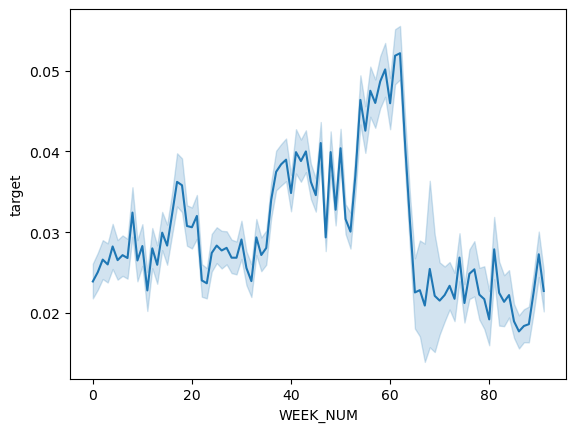

In [20]:
sns.lineplot(data=train_df,x="WEEK_NUM",y="target")
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


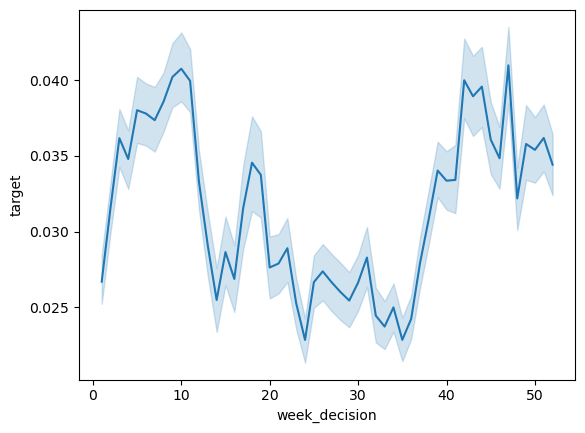

In [21]:
sns.lineplot(data=train_df,x="week_decision",y="target")
plt.show()

## Target variable

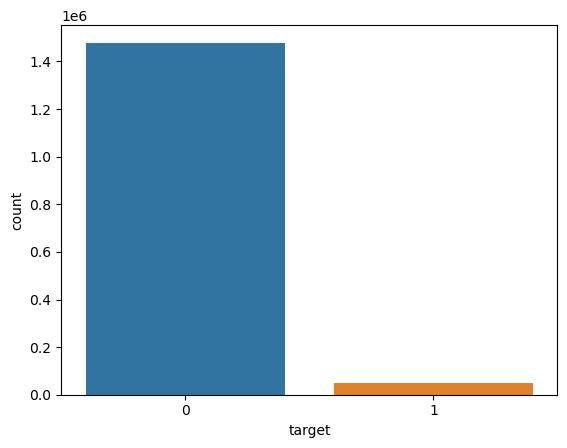

In [22]:
sns.countplot(data=train_df, x='target')
plt.show()

# Pre-processing

In [23]:
features = train_df.drop(['case_id', 'target', "WEEK_NUM"], axis=1)
target = train_df['target']
weeks = train_df['WEEK_NUM']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (1221327, 316), (1221327,)
Test data shape: (305332, 316), (305332,)


# Feature Engineering

In [25]:
boolean_columns = train_df.select_dtypes(include='bool').columns.tolist()
categorical_columns = train_df.select_dtypes(include='category').columns.tolist()

In [26]:
processor = ColumnTransformer(
    transformers=[
        ('boolean', OrdinalEncoder(), boolean_columns),
        ('categorical', OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_columns)
    ], remainder='passthrough'
)

# Metric

# Modeling

In [27]:
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    enable_categorical=True,
    random_state=SEED,
    n_jobs=-1,
)

cat_clf = CatBoostClassifier(
    random_state=SEED,
    loss_function='Logloss',
    cat_features=categorical_columns,
    eval_metric='AUC',
    verbose=False)

lgbm_clf = LGBMClassifier(
    objective="binary", 
    metric='auc',
    random_state=SEED, 
    n_jobs=-1, 
    verbosity=-1
)

In [28]:
%%time
# Cross-validation split
kfold = StratifiedKFold(shuffle=False) 

# StratifiedKFold(shuffle=False)  
# StratifiedGroupKFold(shuffle=False)

auc_scores = []
for train_index, valid_index in kfold.split(X_train, y_train):
    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Train the model
    xgb_clf.fit(X_train_split, y_train_split)
    y_pred = xgb_clf.predict_proba(X_valid_split)[:, 1]

    auc = roc_auc_score(y_valid_split, y_pred)
    auc_scores.append(auc)

print(f'\nMean AUC: {np.mean(auc_scores)}\n')


Mean AUC: 0.8378013393414468

CPU times: user 11min 15s, sys: 1min 28s, total: 12min 44s
Wall time: 2min 39s


In [29]:
%%time
# Cross-validation split
kfold = StratifiedKFold(shuffle=False) 

# StratifiedKFold(shuffle=False)  
# StratifiedGroupKFold(shuffle=False)

auc_scores = []
for train_index, valid_index in kfold.split(X_train, y_train):
    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Train the model
    lgbm_clf.fit(X_train_split, y_train_split)
    y_pred = lgbm_clf.predict_proba(X_valid_split)[:, 1]

    auc = roc_auc_score(y_valid_split, y_pred)
    auc_scores.append(auc)

print(f'\nMean AUC: {np.mean(auc_scores)}\n')


Mean AUC: 0.8408303209886249

CPU times: user 9min 39s, sys: 24.1 s, total: 10min 3s
Wall time: 2min 27s


# Evaluation

In [30]:
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f'XGB AUC: {auc_xgb}')

XGB AUC: 0.8395381109974269


In [31]:
lgbm_clf.fit(X_train, y_train)
y_pred_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]
auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)
print(f'LGBM AUC: {auc_lgbm}')

LGBM AUC: 0.8388871689226173


# Prediction & Submit

In [32]:
# Retrain before prediction
xgb_clf.fit(features, target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [33]:
test_df.drop(["case_id", "WEEK_NUM"], axis=1, inplace=True)
predictions = xgb_clf.predict_proba(test_df)[:, 1]

In [34]:
sub = pd.read_csv('submission.csv')
sub['score'] = predictions
sub.to_csv('submission.csv', index=False)

# Reference

- [Home Credit Baseline](https://www.kaggle.com/code/greysky/home-credit-baseline)
